In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
act = pd.read_csv("../data/ageact_mod.csv")
act["kepid"] = np.array([float(i) for i in act["#KIC"].values])
act

,#KIC,Teff,Teff_err,[M/H],[M/H]_err,Sindex,S/N,Age[Gyr],Age_err+,Age_err-,Source,kepid
0,1435467,6326.0,77.000,0.010,0.100,0.1461,12.78,3.0164,0.4951,0.3513,LEGACY,1435467.0
1,2837475,6614.0,77.000,0.010,0.100,0.1400,12.60,1.6270,0.1118,0.1757,LEGACY,2837475.0
2,2852862,6008.1,69.276,-0.155,0.100,0.1260,27.88,4.5070,0.3910,0.3390,APOGEE,2852862.0
3,3223000,5851.5,69.276,-0.185,0.100,0.1986,50.82,8.9810,2.0300,1.6650,APOGEE,3223000.0
4,3424541,6278.9,69.276,0.270,0.100,0.1505,11.28,1.5230,0.1290,0.1160,APOGEE,3424541.0
...,...,...,...,...,...,...,...,...,...,...,...,...
120,12069424,5825.0,50.000,0.100,0.030,0.1484,99.90,6.6735,0.8145,0.7666,LEGACY,12069424.0
121,12069449,5750.0,50.000,0.050,0.020,0.1536,99.90,7.3922,0.8943,0.9103,LEGACY,12069449.0
122,12258514,5964.0,77.000,-0.000,0.100,0.1420,25.71,4.0544,0.1757,0.1597,LEGACY,12258514.0
123,12265063,5708.3,69.276,-0.268,0.101,0.1281,11.20,10.6800,1.4020,1.3240,APOGEE,12265063.0


In [4]:
from astropy.io import fits

gaia_file = "/Users/rangus/projects/data/kepler_dr2_1arcsec.fits"

with fits.open(gaia_file) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
    
df = pd.merge(act, gaia, how="left", on="kepid")
print(np.shape(act), np.shape(gaia), np.shape(df))

(125, 12) (197090, 101) (127, 112)


In [5]:
def r_prime_hk_from_sindex_and_teff(sindex, teff, mh):
    log_C_cf = - 7.31 + 2.25e-3 * teff - 1.70e-7 * teff**2
    log_r_phot = - 4.78845 - (3.70700 / (1. + (teff/4598.92)**17.5272))
    log_r_hk = np.log10(1.34e-4 * 10**log_C_cf * sindex)
    return log_r_hk + 0.5 * mh 

#     logC2 = (-1.70e-7*teff*teff)+(2.25e-3*teff)-7.31
#     Rhk2 = sindex*0.000134*10**(logC2)
#     Rphot2 = 10**(-4.78845-(3.70700/(1.+(teff/4598.92)**17.5272)))
#     return Rhk2-Rphot2

log_r_prime_hk = r_prime_hk_from_sindex_and_teff(df.Sindex.values, df.Teff.values, df["[M/H]"].values)

In [6]:
df["log_r_prime_hk"] = log_r_prime_hk
df.to_csv("../data/TM_age_activity.csv")

Just look at stars with Solar like Teffs.

In [24]:
bprp = df.phot_bp_mean_mag.values - df.phot_rp_mean_mag.values
age_err = .5*(df["Age_err+"].values + df["Age_err-"].values)

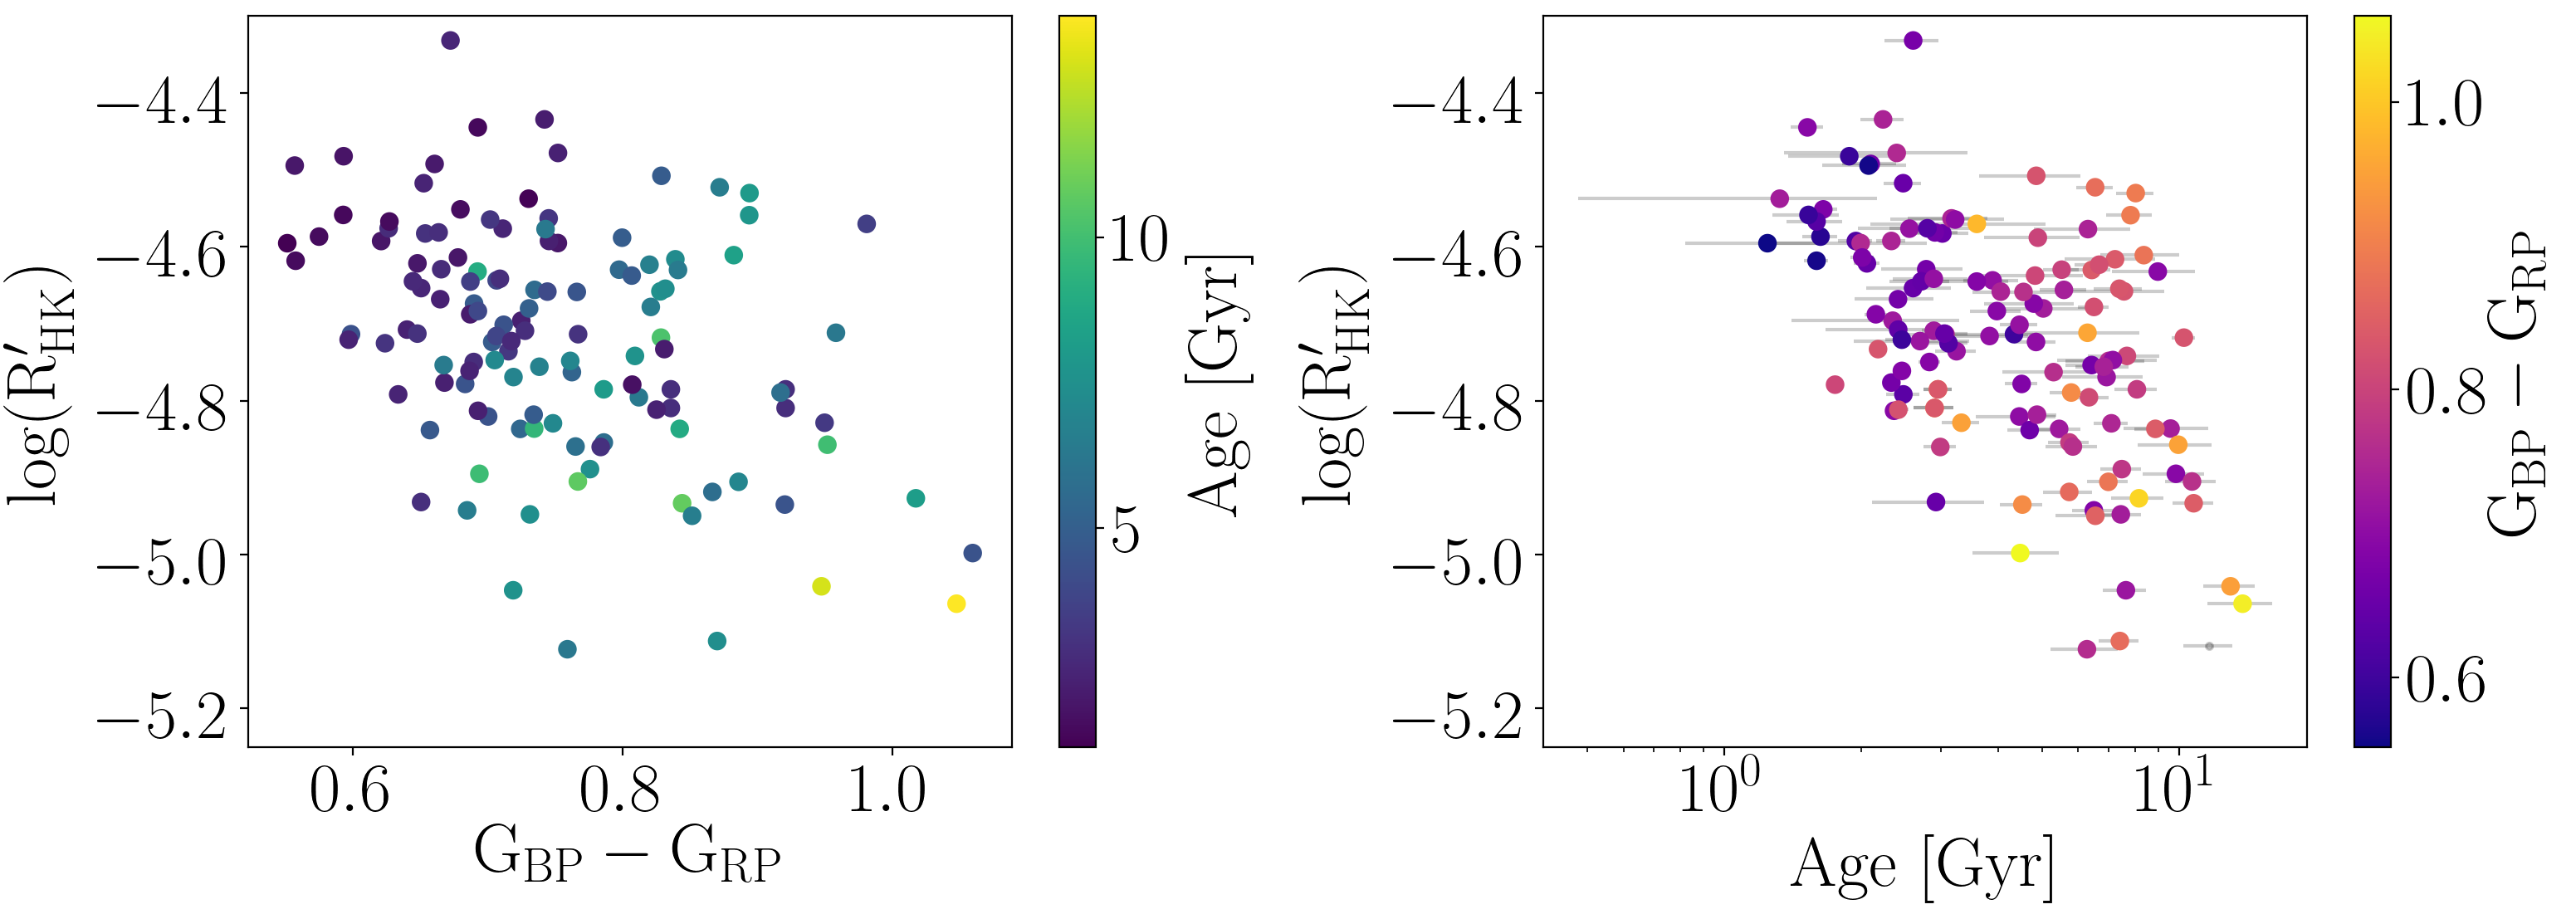

In [23]:
m = df.Teff.values > 0

fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(bprp[m], log_r_prime_hk[m], c=df["Age[Gyr]"][m], s=50)
plt.colorbar(cb, label="$\mathrm{Age~[Gyr]}$")
ax0.set_xlabel("$\mathrm{G_{BP} - G_{RP}}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
ax0.set_ylim(-5.25, -4.3)

ax1 = fig.add_subplot(122)
ax1.errorbar(df["Age[Gyr]"].values[m], log_r_prime_hk[m], xerr=age_err[m], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(df["Age[Gyr]"].values[m], log_r_prime_hk[m], c=bprp[m], s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{G_{BP} - G_{RP}}$")
ax1.set_xlabel("$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");
ax1.set_ylim(-5.25, -4.3)
ax1.set_xscale("log")

plt.tight_layout()

In [25]:
def model(p, logbprp, logage):
    # rhk = f(bprp) g(age)
    # prot = age^n * a*(B-V-c)^b
    # logprot = n*log(age) + log(a) + b*log(B-V-c)
    # logrhk = n*log(age) + b*log(bprp) + c
    return p[0] + p[1]*logage + p[2]*logbprp

def nll(p, logbprp, logage, logrhk, logrhk_err):
    mod = model(p, logbprp, logage)
    var = logrhk_err**2
    return - np.sum(-.5 * (mod - logrhk)**2/var - .5*np.log(2*np.pi*var))

def lnlike(p, logbprp, logage, logrhk, logrhk_err):
    mod = model(p, logbprp, logage)
    var = logrhk_err**2
    return np.sum(-.5 * (mod - logrhk)**2/var - .5*np.log(2*np.pi*var))

In [29]:
import scipy.optimize as sco

logage = np.log10(df["Age[Gyr]"])
logbprp = np.log10(bprp)
logrhk = log_r_prime_hk

p0 = np.ones(3)
result = sco.minimize(nll, p0, args=(logbprp, logage, logrhk, np.ones_like(logrhk)*.1))
print("parameters = ", list(result.x))

parameters =  [-4.605009128397536, -0.29167537607227884, -0.4492506471070508]


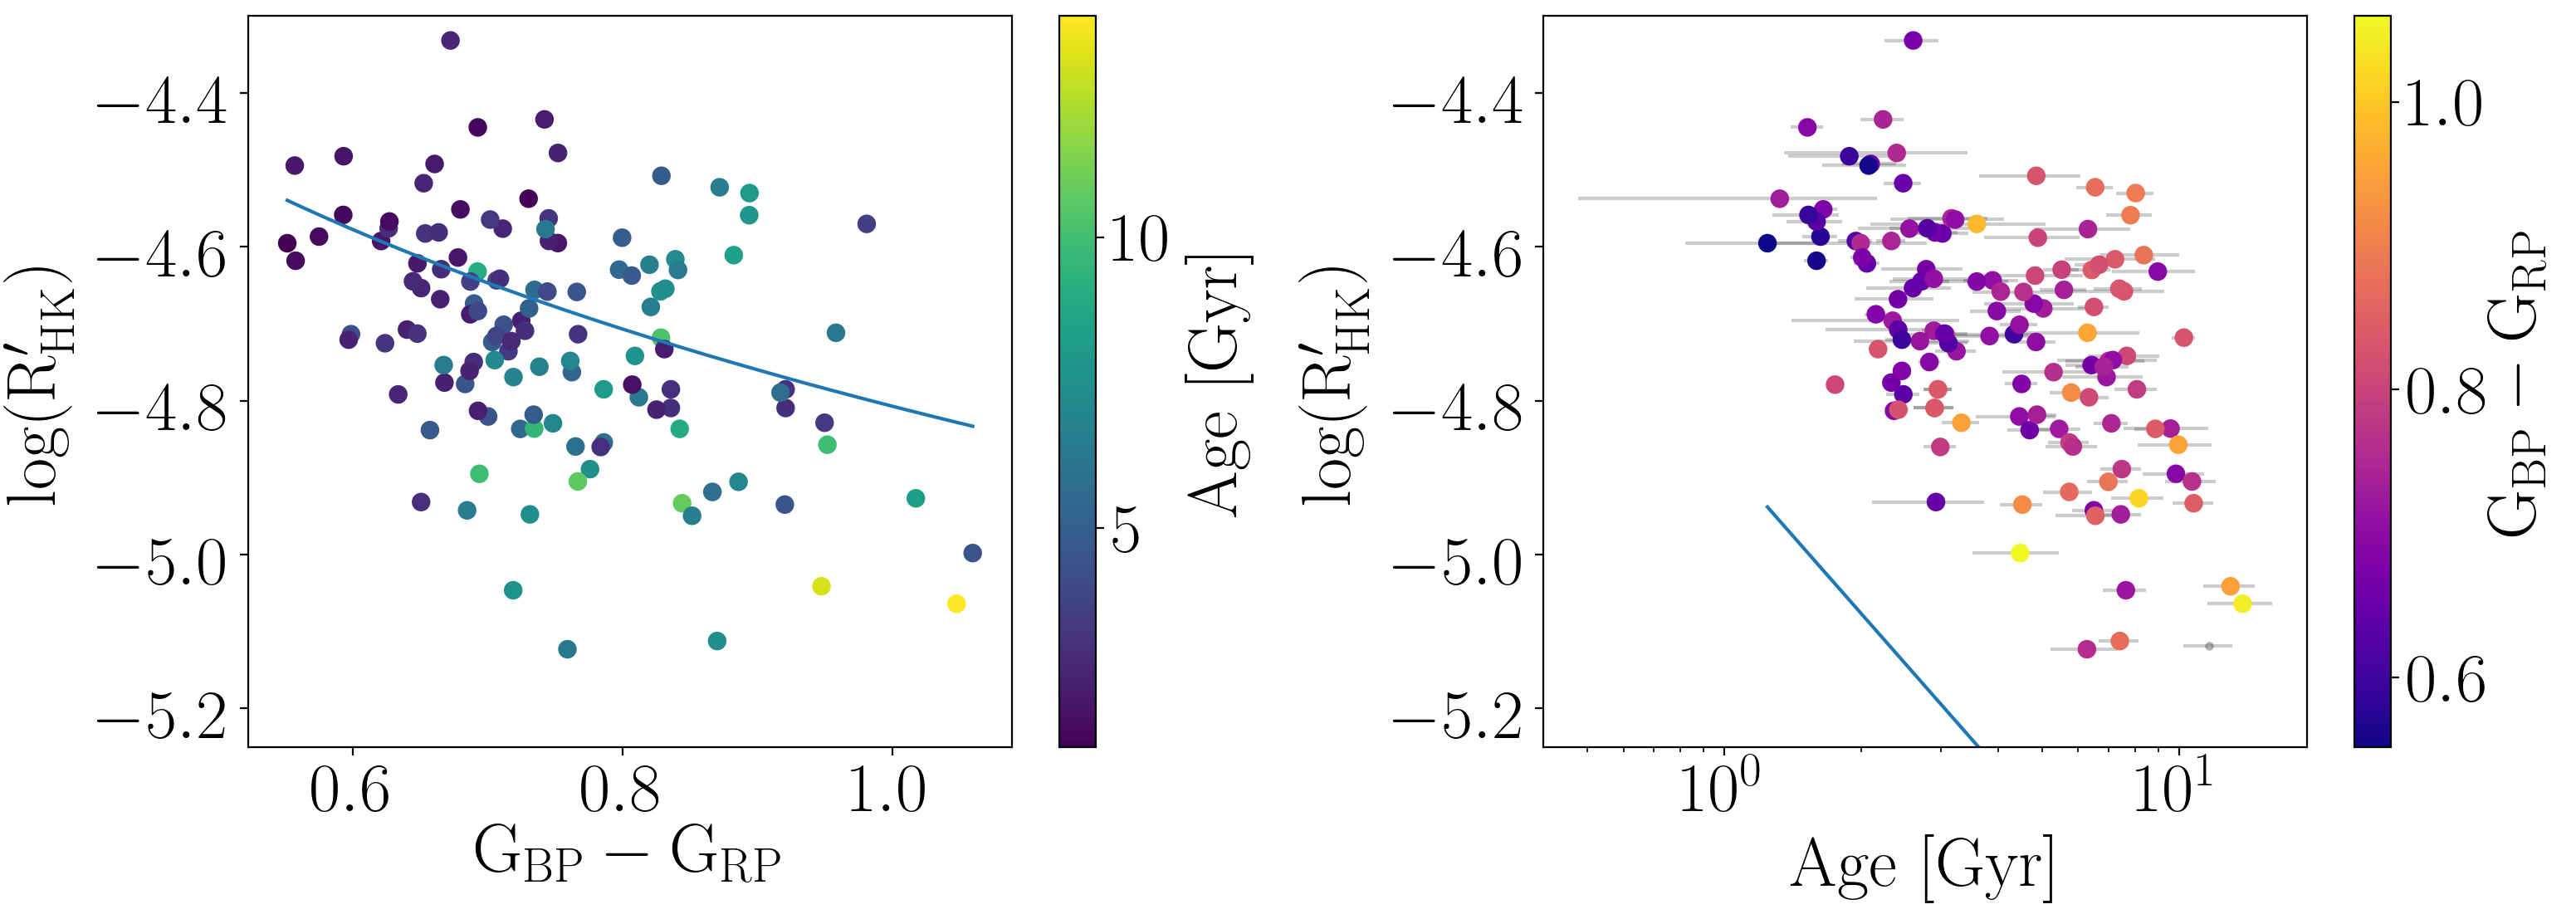

In [35]:
m = df.Teff.values > 0

bprps = np.linspace(min(bprp), max(bprp))
ages = np.linspace(min(df["Age[Gyr]"]), max(df["Age[Gyr]"]))

fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(bprp[m], log_r_prime_hk[m], c=df["Age[Gyr]"][m], s=50)

ax0.plot(bprps, model(list(result.x), np.log(bprps), np.log(2)))

plt.colorbar(cb, label="$\mathrm{Age~[Gyr]}$")
ax0.set_xlabel("$\mathrm{G_{BP} - G_{RP}}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
ax0.set_ylim(-5.25, -4.3)

ax1 = fig.add_subplot(122)
ax1.errorbar(df["Age[Gyr]"].values[m], log_r_prime_hk[m], xerr=age_err[m], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(df["Age[Gyr]"].values[m], log_r_prime_hk[m], c=bprp[m], s=50, zorder=1, cmap="plasma")

ax1.plot(ages, model(list(result.x), .6, np.log(ages)))

plt.colorbar(cb, label="$\mathrm{G_{BP} - G_{RP}}$")
ax1.set_xlabel("$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");
ax1.set_ylim(-5.25, -4.3)
ax1.set_xscale("log")

plt.tight_layout()